# **SHAP Plots / Linear explainer**

Notebook for demostrating and understanding the plots from a shap explainable model. 

## **Imports and package instalations**

In [1]:
pip install shap==0.39

     |████████████████████████████████| 358kB 5.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491628 sha256=c56ae6729a0fbab193522a754bb73fc6d8ea768b95f6f629c1c081aed43e2fb9
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [2]:
import pandas as pd
import shap
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
from ipywidgets import interact

## **Regression Data**


We will be using the boston housing dataset with only 4 features. It is not the best example as we are removing most of the information and variables, but for demonstrating and understanding the plots that come out of shap is good to have a small number of features. We will pick the most relevant ones as chosen as the ones whith a higher $w$ value in the full dataset's `LinearRegression`.

In [3]:
X_full, Y_full = shap.datasets.boston()
X_train, X_test, Y_train, Y_test = train_test_split(X_full, Y_full, test_size=0.2, random_state=0)
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, Y_train)
all_coefs = list(zip(X_full.columns, model.coef_))
best_feats_and_coefs = sorted(all_coefs, key=lambda x: x[1], reverse=True)[:4]
most_relevant_features = list(map(lambda x: x[0], best_feats_and_coefs))
print(f'{most_relevant_features} are the most relevant features for the linear classifier and thus will be used')

['RM', 'CHAS', 'RAD', 'ZN'] are the most relevant features for the linear classifier and thus will be used


We remove the features that we do not deem relevant from the dataset.

In [4]:
X_train = X_train[most_relevant_features]
X_test = X_test[most_relevant_features]

We inspect the resulting test set:

In [5]:
X_test_disp = X_test.copy()
X_test_disp['house_price (/1000)'] = Y_test
X_test_disp.sort_index()

,RM,CHAS,RAD,ZN,house_price (/1000)
1,6.421,0.0,2.0,0.0,21.6
10,6.377,0.0,5.0,12.5,15.0
12,5.889,0.0,5.0,12.5,21.7
15,5.834,0.0,4.0,0.0,19.9
21,5.965,0.0,4.0,0.0,19.6
...,...,...,...,...,...
481,6.750,0.0,24.0,0.0,23.7
487,5.905,0.0,24.0,0.0,20.6
495,5.670,0.0,6.0,0.0,23.1
497,5.794,0.0,6.0,0.0,18.3


### Linear Regression training
First we train a linear regressor.

In [6]:
# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Then we can create a `shap.LinearExplainer` object to extract the shap_values from the model.

In [7]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer(X_test)

### Prediction Explainer

#### Force Plot

These plots aim to explain individual predictions. The mopdel predicted a median output value of `0.9388`. We can also see that each of the features contribute to the value getting bigger (red) or smaller (blue). In this case, we can see that the feature that contributted the most is petal_width. However, it's not very apparent in the force_plot.

In [8]:
shap.initjs()
shap.plots.force(shap_values[0])

#### Waterfall

The waterfall plot unfolds the predicted contributions from the force plot into a 2D cascade where the importance and the contribution of each of the attributes is made more apparent and it can easily be seen as a sequential progression starting from the expected value for the whole dataset and showing the deviations contributed by each of the features to finally extract the value expected.

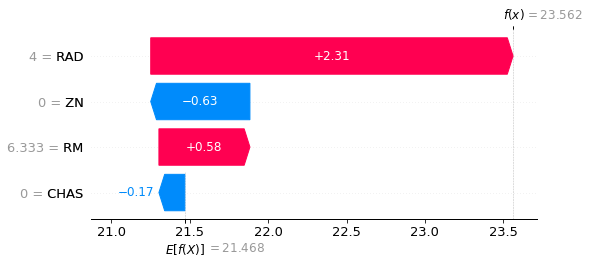

In [9]:
shap.plots.waterfall(shap_values[0], max_display=20)

### Model Explainer

This chart has the purpose of explaining the model as a whole. It essentially has all the samples plotted on the x-axis (in this case, ordered by similarity) and their prediction values plotted on the y-axis. Also, it has the individual contributions of each feature for each sample, based on feature value.

In [10]:
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values.values, X_test)

This plot can be also understood as the 1D force plot that we had before for every sample in the set, stacked into a 2D plot and then rotated 90°. Then the values are sorted by similarity in this case but in the top pop up menu, the difference 1D force plots can be sorted and in the pop up menu on the right the feature(s) to display can be selected.

### Dependance Plot

In this chart we can see how 2 features are related to one another in terms of their impact in the model, measured by SHAP value. SHAP values can also be seen as an chance. A $value< 0$ for a particular feature means observing that feature lowers your log chances of winning by $\|value\|$, where “winning” here just means having a higher regression value.

In this case we can see that for values of petal length below ~3.5 (x-axis), the SHAP values (y-axis) are always negative, which means lower values of this feature push the prediction value down. This means that the lower the possible value.

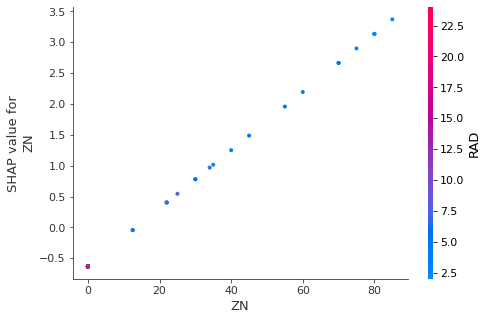

In [11]:
shap.dependence_plot("ZN", shap_values.values, X_test)

The heatmap also adds another dimension in the plot, where the value of petal width is also present. In this case, the plot demonstrates that the features `peta_length` and `petal_width` are highly correlated in terms of their shap values.

### Summary Plot

This chart shows a general evaluation of feature relevance on the model as a whole. It considers the feature relevance for each individual prediction (depicted as a point). Also, for each feature, it shows how a higher or lower value of that feature influences the fact that it agrees or disagrees with the prediction.

In this case, as we are talking about a linear predictor, if the value agrees with the prediction it denotes that the slope of the $y=wx+b$ equation caracteristic of linear models follows $w>0$. If the prediction disagrees with the prediction, it means that the slope $w<0$

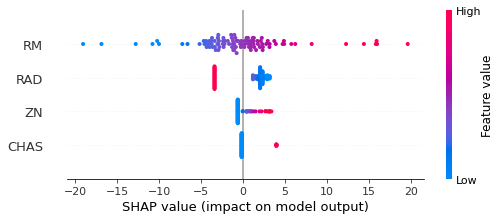

In [12]:
shap.summary_plot(shap_values, X_test)

## **Classification Data**

For an example in classification we will use the `shap.datasets.iris()` dataset.

In [13]:
X_iris_train, X_iris_test, Y_iris_train, Y_iris_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)

We can now take a look at some of the test instances of the test partition:

In [14]:
X_test_disp = X_iris_test.copy()
X_test_disp['class (int)'] = Y_iris_test
X_test_disp.sort_index().head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class (int)
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
16,5.4,3.9,1.3,0.4,0
22,4.6,3.6,1.0,0.2,0
24,4.8,3.4,1.9,0.2,0


### Model Training
We train a perceptron, a multivariate linear classifier as a baseline for demonstrating the plots from a `shap.LinearExplainer` object.

In [15]:
model = sklearn.linear_model.Perceptron()
model.fit(X_iris_train, Y_iris_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

Create a `shap.LinearExplainer` object, fit it to the `X_iris_test` data and obtain the SHAP values fot those instances. 

In [16]:
explainer = shap.LinearExplainer(model, X_iris_train)
shap_values = explainer.shap_values(X_iris_test)

In [17]:
for feat_idx, feat_shap in enumerate(shap_values):
  print(f'Shap values\' shape for {feat_idx}th feature: {feat_shap.shape}')

Shap values' shape for 0th feature: (30, 4)
Shap values' shape for 1th feature: (30, 4)
Shap values' shape for 2th feature: (30, 4)


#### Force Plots

As we are dealing with a multiclass classification problem, instead of observing the changes of the output variable as we did in the regression example, we will now be observing how each variable contributes to the change in probability of each of the classes.

##### Iris Setosa

In [18]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_iris_test.iloc[0,:], link="logit")

##### Iris Versicolor

In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_iris_test.iloc[0,:], link="logit")

##### Iris Virginica

In [20]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0,:], X_iris_test.iloc[0,:], link="logit")

#### Model Explainer



##### Iris Setosa

In [21]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_iris_test, link="logit")

##### Iris Versicolor

In [22]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_iris_test, link="logit")

##### Iris Virginica

In [23]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2], X_iris_test, link='logit')

#### MultiClass Summary Plot

In the following summary plot, the contribution of each feature to each of the classes is reported in a stacked bar plot. Where adding them all for each feature provides a numerical representation of the relevance of the feature to the model prediction.

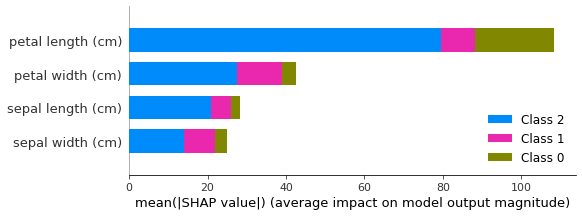

In [24]:
shap.summary_plot(shap_values, X_iris_test)

#### Summary Plot

##### Iris Setosa

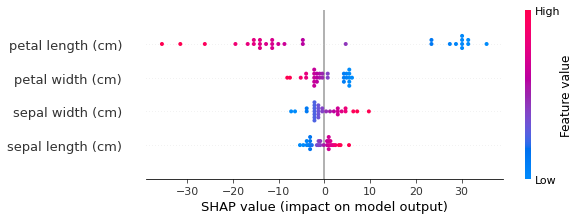

In [25]:
shap.summary_plot(shap_values[0], X_iris_test)

##### Iris Versicolor

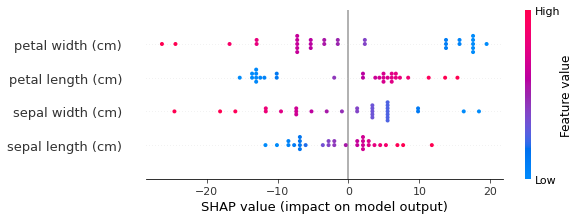

In [26]:
shap.summary_plot(shap_values[1], X_iris_test)

##### Iris Virginica

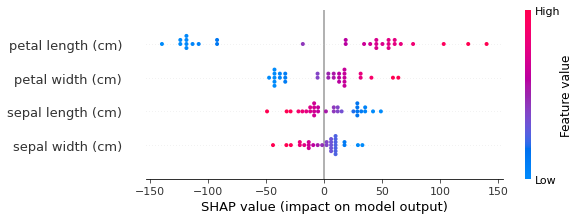

In [27]:
shap.summary_plot(shap_values[2], X_iris_test)

#### Dependance plots

##### Iris Setosa

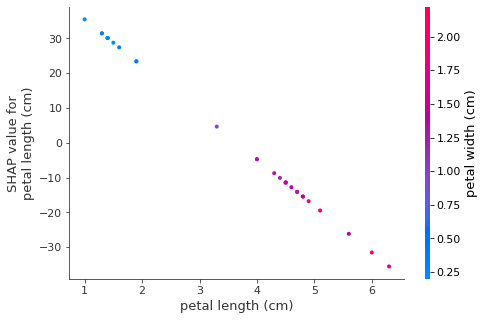

In [28]:
shap.dependence_plot("petal length (cm)", shap_values[0], X_iris_test)

##### Iris Versicolor

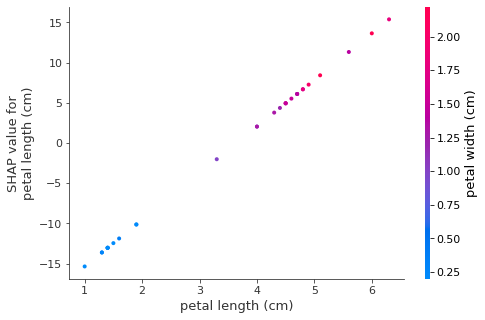

In [29]:
## Virginica output
shap.dependence_plot("petal length (cm)", shap_values[1], X_iris_test)

##### Iris Virginica

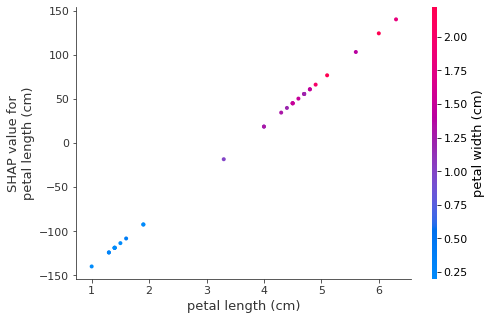

In [30]:
## Virginica output
shap.dependence_plot("petal length (cm)", shap_values[2], X_iris_test)

# **END**